##Required installation






In [ ]:
!pip install transformers -q --quiet
!pip install datasets -q --quiet
!pip install tensorflow -q --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 94.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.1 MB/s eta 0:00:00


##Importing data and processing the data

In [ ]:
TRAIN_DATASET_PATH = "train.csv" # directory path where the training dataset is located
TEST_DATASET_PATH = "test.csv" # directory path where the test dataset is located

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df = test_df.dropna()
train_df = train_df.dropna()

# This hyperparameter can be set and has a preferred range between 0.1 and 0.2
validation_split = 0.1
train_df,val_df = train_test_split(train_df, test_size = validation_split, random_state = 100)
# When splitting data, an index column will be added. It is dropped using this command
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
from datasets import Dataset
import pyarrow as pa

# Converting DataFrame to a Dataset: a required step for using hugging face pipline
df_train = Dataset(pa.Table.from_pandas(train_df))
df_test = Dataset(pa.Table.from_pandas(test_df))
df_val = Dataset(pa.Table.from_pandas(val_df))
print(df_train,df_test,df_val)

Dataset({
    features: ['news', 'source', 'label'],
    num_rows: 2069
}) Dataset({
    features: ['news', 'source', 'label'],
    num_rows: 500
}) Dataset({
    features: ['news', 'source', 'label'],
    num_rows: 230
})


##Importing Model and ModelTokeniszer

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

# This is a Hugging Face model token which is a unique identifier used to instantiate and utilize pre-trained models through the Hugging Face library.
model_tk = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = model_tk) # Calling the tokensizer for the model

##Tokenization of the Data

In [ ]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch['news'], padding = True, truncation = True, add_special_tokens = True, max_length = 512)
# We are tokenizing the the data
df_train_tokenised = df_train.map(tokenize, batched=True)
df_test_tokenised = df_test.map(tokenize, batched=True)
df_val_tokenised = df_val.map(tokenize, batched=True)
print(df_train_tokenised,df_test_tokenised,df_val_tokenised)

Map:   0%|          | 0/2069 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/230 [00:00<?, ? examples/s]

Dataset({
    features: ['news', 'source', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2069
}) Dataset({
    features: ['news', 'source', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 500
}) Dataset({
    features: ['news', 'source', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 230
})


##Data Reconstruction to accommodate the model

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding

# Data collator is a simple object which divides the data in to batches.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
# Hyperparameter you can vary to change the batch size
batch_size = 16
# Create tensorflow datasets for train and validation
tf_train_dataset = df_train_tokenised.to_tf_dataset(
    columns = ['input_ids'],
    label_cols = ['label'],
    shuffle = False,
    batch_size = batch_size,
    collate_fn = data_collator
)
tf_valid_dataset = df_val_tokenised.to_tf_dataset(
    columns = ['input_ids'],
    label_cols = ['label'],
    shuffle = False,
    batch_size = batch_size,
    collate_fn = data_collator
)
print(tf_train_dataset,tf_valid_dataset)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:385: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 80), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


##Optimizer and Loss Function

In [ ]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay


# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_epochs = 20
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5,
    end_learning_rate=0.0,
    decay_steps=num_train_steps
)

In [ ]:
import tensorflow.keras.optimizers as opt

# The Adam optimizer was imported and utilized in conjunction with the previously defined scheduler.
# This choice was made as the scheduler was found to be effective in enhancing the results by regulating the learning rate.
optimizer = opt.Adam(learning_rate=lr_scheduler,
    weight_decay=0.004,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07)

##Model Compilation and Execution



In [ ]:
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras import metrics
from tensorflow.keras import losses

# Calling the model with its pretrained weights
model = TFAutoModelForSequenceClassification.from_pretrained(model_tk,from_pt=True,trainable=True)
# Compilation of the model with the above definied optimiser and using SparseCategoricalCrossentropy and  SparseCategoricalAccuracy metrics which were
model.compile(
    optimizer = optimizer,
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = metrics.SparseCategoricalAccuracy()
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from keras.callbacks import EarlyStopping

# This early stopping callback is  used in order to prevent overfitting
# Here patience is a hyperparameter that can be set
early_stopping_callback = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 2, patience = 6)

In [ ]:
# Fit the model
history_embedding = model.fit(tf_train_dataset, batch_size = batch_size, validation_data = tf_valid_dataset, epochs = num_epochs, callbacks = [early_stopping_callback])

Epoch 1/20
130/130 [==============================] - 133s 405ms/step - loss: 0.4774 - sparse_categorical_accuracy: 0.8086 - val_loss: 0.4306 - val_sparse_categorical_accuracy: 0.8391
Epoch 2/20
130/130 [==============================] - 43s 334ms/step - loss: 0.3966 - sparse_categorical_accuracy: 0.8536 - val_loss: 0.5295 - val_sparse_categorical_accuracy: 0.7739
Epoch 3/20
130/130 [==============================] - 41s 318ms/step - loss: 0.3596 - sparse_categorical_accuracy: 0.8690 - val_loss: 0.4142 - val_sparse_categorical_accuracy: 0.8696
Epoch 4/20
130/130 [==============================] - 40s 308ms/step - loss: 0.3080 - sparse_categorical_accuracy: 0.8840 - val_loss: 0.3606 - val_sparse_categorical_accuracy: 0.8609
Epoch 5/20
130/130 [==============================] - 40s 309ms/step - loss: 0.2301 - sparse_categorical_accuracy: 0.9116 - val_loss: 0.4253 - val_sparse_categorical_accuracy: 0.8957
Epoch 6/20
130/130 [==============================] - 42s 322ms/step - loss: 0.1819 

## Performance Visualizations

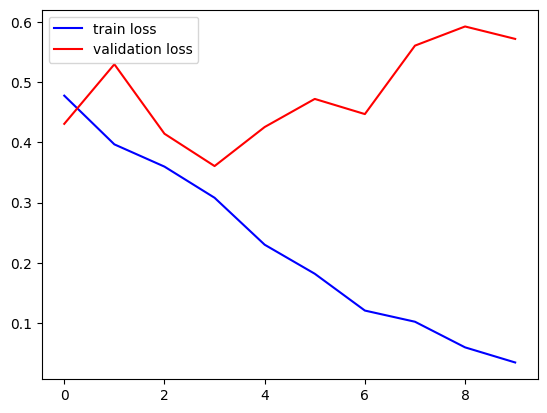

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the graph between training and  validation loss
plt.plot(history_embedding.history['loss'], c = 'b', label = 'train loss')
plt.plot(history_embedding.history['val_loss'], c = 'r', label = 'validation loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np

# Predicting the labels for the test dataset
outputs = model.predict(df_test_tokenised['input_ids'])
outputs = outputs['logits'].tolist()
# The "argmax" function was employed to determine the index of the maximum value, which serves as our label indirectly.
pred = np.argmax(outputs,axis=1)

16/16 [==============================] - 6s 171ms/step


In [ ]:
from sklearn.metrics import classification_report

# Classification report
print(classification_report( pred, test_df['label']))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       201
           1       0.89      0.89      0.89       299

    accuracy                           0.87       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.87      0.87      0.87       500



<Axes: >

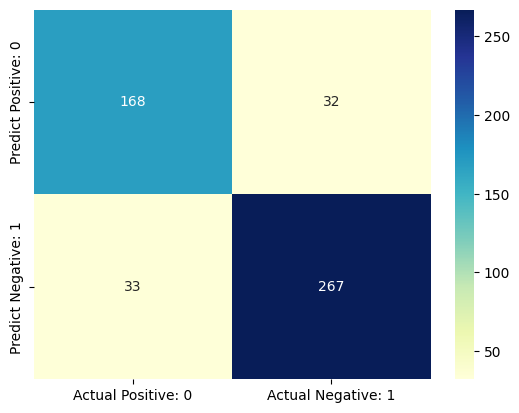

In [ ]:
from sklearn.metrics import  confusion_matrix

# Confusion matrix
cm = confusion_matrix(df_test['label'], pred)
cm_matrix = pd.DataFrame(data = cm, columns = ['Actual Positive: 0', 'Actual Negative: 1'], index = ['Predict Positive: 0', 'Predict Negative: 1'])
sns.heatmap(cm_matrix, annot = True, fmt = 'd', cmap = 'YlGnBu')